# Install the necessary packages

In [ ]:
# Load libraries:
library(tidyverse) # metapackage of all tidyverse packages
library(jsonlite) # - jsonlite: stream large, line-delimited JSON files
library(tidyr) # - tidyr:    unnest/flatten list-columns
library(purrr) # - purrr:    map() to normalize NULLs in list-columns

In [ ]:
# Read the Yelp business JSON file efficiently
business_df <- jsonlite::stream_in(
  # Open the file from the Kaggle input folder
  file("/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json"),
  
  # Flatten nested fields (like attributes and hours) into normal columns
  flatten = TRUE
)

# Result: 'business_df' is a tidy data frame with all business info in flat columns


# Understanding the Structure of the Data

In [ ]:
# Check structure
glimpse(business_df)

# Selecting And Examining Column Data Types

* Let's examine the structure of certain columns
* We will ignore anything with "hours" or "attribute" it's the name

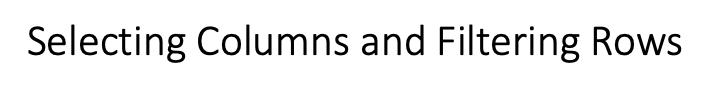
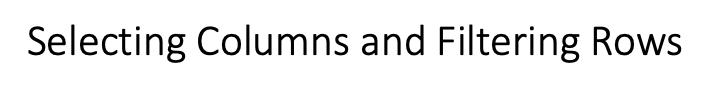
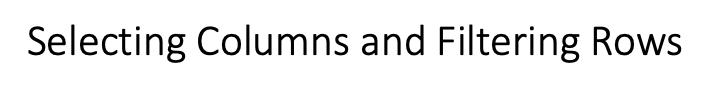
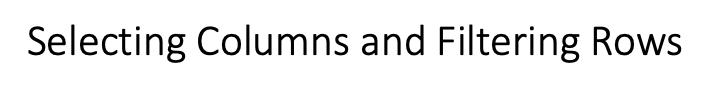
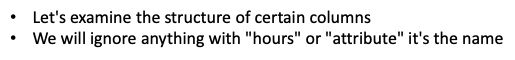
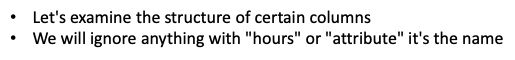
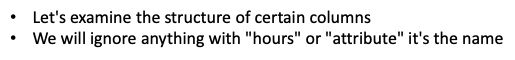
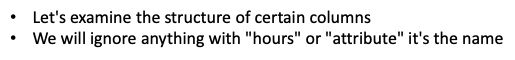
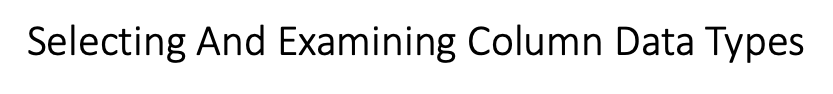
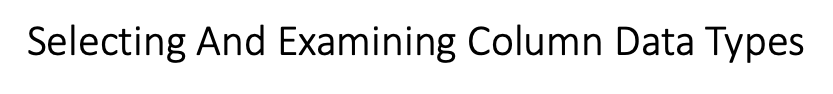
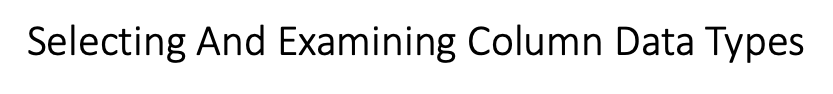
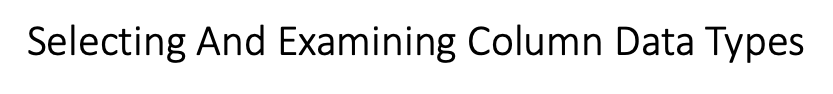

In [ ]:
# Select all columns except those starting with "hours" or "attribute"
business_df %>%
  select(-starts_with("hours"), -starts_with("attribute")) %>%  # Remove all columns that start with "hours" or "attribute"
  head(5)   # Display the first 5 rows


# Filtering Rows
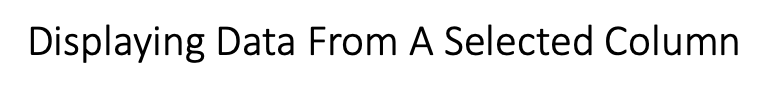
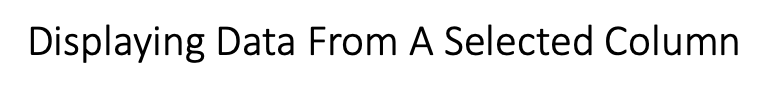
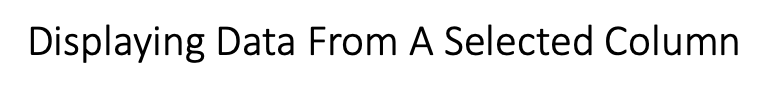
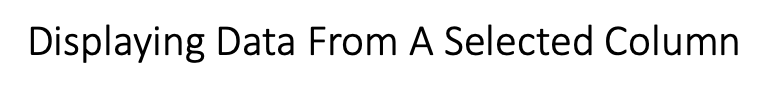

In [ ]:
# Select and filter restaurant data
business_df %>%
  select(categories) %>%                           # Keep only the 'categories' column
  filter(str_detect(categories, "Restaurant"))%>%  # Filter rows containing the word "Restaurant"
    head (5)


# Splitting, Mutating And Unnesting
* Separate the the elements in the the categories column at the delimiter(,)
* Place each element onto a separate row
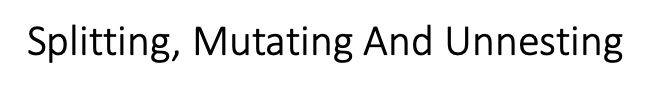
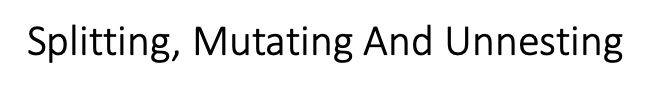
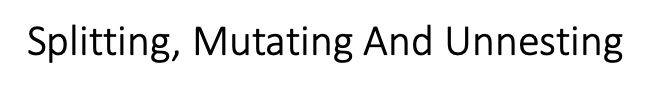
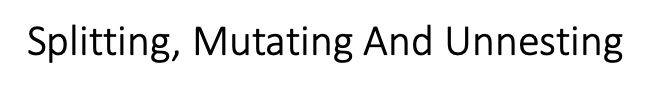
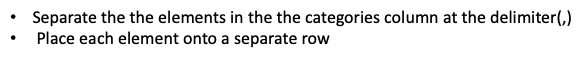
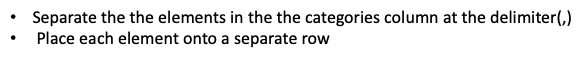
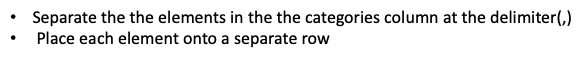
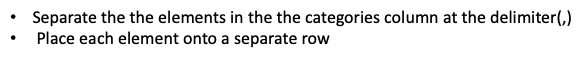

In [ ]:
# Filter and expand restaurant categories
business_df %>%
  filter(str_detect(categories, "Restaurant")) %>%         # Keep only rows where 'categories' contains "Restaurant"
  mutate(categories_new = strsplit(categories, ",")) %>%   # Split the 'categories' column into a list using commas as separators
  unnest(categories_new) %>%                               # Expand the list so each category appears in its own row
  select(name, categories_new) %>%                         # Keep only business name and category columns
    head (5)



# Remove Unnecessary Spaces
* Ultimately, we would like to group and count the number of different categories associated with restaurants.
* Notice that there is a space before some of the elements in the categories column  
* This may be problematic when we group and count the observations.
* Let's remove all unnecessary spaces
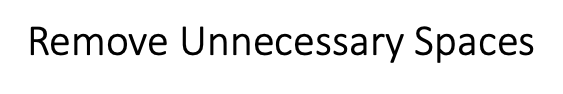
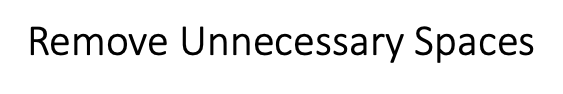
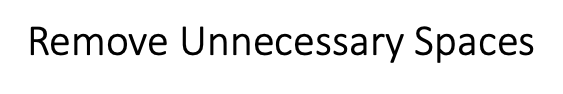
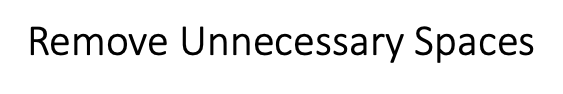
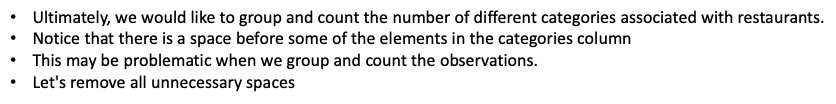
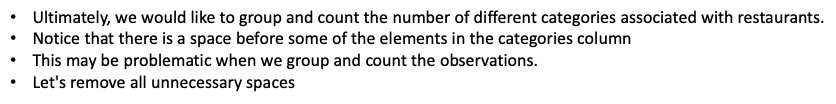
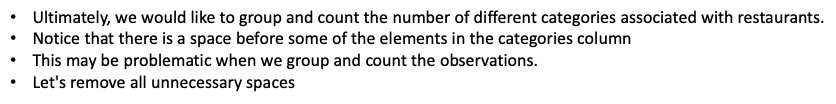
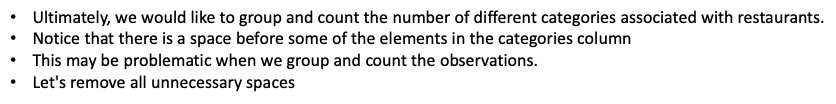

In [ ]:
# Filter, split, clean, and preview restaurant categories
business_df %>%
  filter(str_detect(categories, "Restaurant")) %>%                   # Keep only restaurant rows
  mutate(categories_new = strsplit(categories, ",")) %>%             # Split categories by comma
  unnest(categories_new) %>%                                         # Expand each category to its own row
  select(name, categories_new) %>%                                   # Keep name and category
  mutate(categories_new = str_trim(str_squish(categories_new))) %>%  # Remove extra spaces
  head(5)                                                            # Show first 5 rows


# Remove Unnecessary Spaces: Alternative Approach
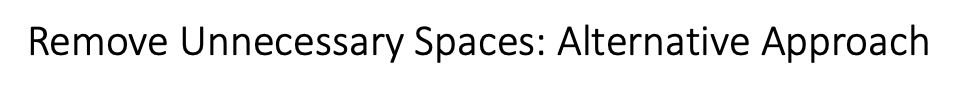
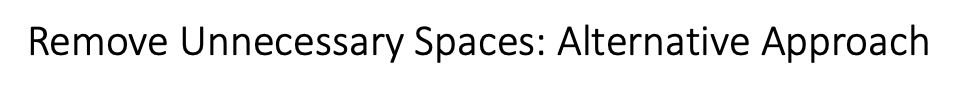
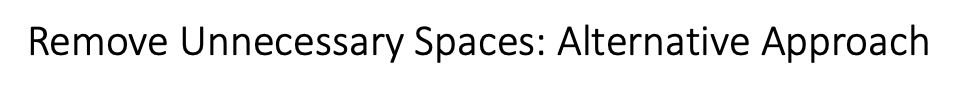
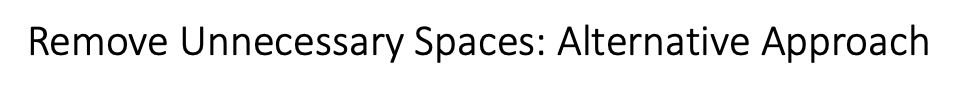

In [ ]:
# Filter, clean, and preview restaurant categories
business_df %>%
  filter(str_detect(categories, "Restaurant")) %>%                   # Keep only restaurant rows
  mutate(categories_new = strsplit(categories, ",")) %>%             # Split multiple categories by comma
  unnest(categories_new) %>%                                         # Expand each category into its own row
  select(name, categories_new) %>%                                   # Keep business name and category
  mutate(categories_new = str_trim(str_squish(categories_new))) %>%  # Remove extra spaces
  head(5)                                                            # Show first 5 results


# Count and Sort
* Count the number of different categories associated with restaurants and sort them them from most to least

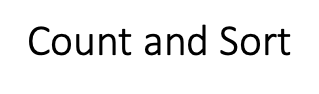
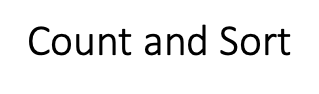
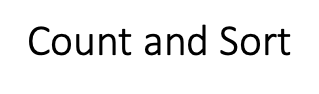
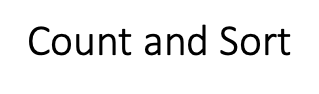
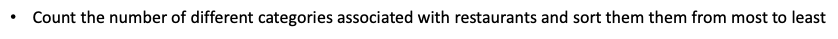
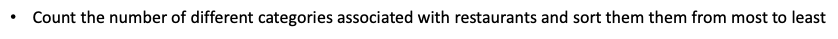
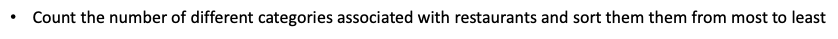
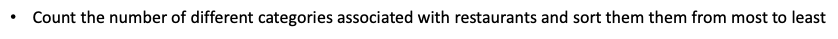

In [ ]:
# Filter, clean, count, and sort restaurant categories
business_df %>%
  filter(str_detect(categories, "Restaurant")) %>%            # Keep only rows with 'Restaurant'
  mutate(categories_new = strsplit(categories, ",")) %>%      # Split categories into lists
  unnest(categories_new) %>%                                  # Expand each category into its own row
  select(name, categories_new) %>%                            # Keep business name and category
  mutate(categories_new = str_trim(str_squish(categories_new))) %>%  # Clean up spaces
  count(categories_new) %>%                                   # Count how often each category appears
  arrange(desc(n))                                            # Sort by most common categories


# Filter
* Let's see which are the most popular types of categories in each state or province
* We will filter out the words "Restaurant" and "Food" since those are likely to be common for all the establishments

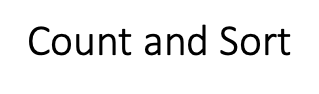
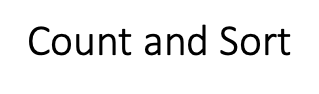
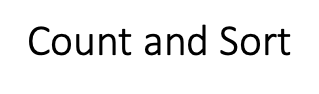
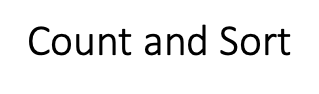
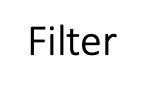
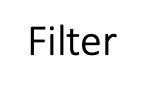
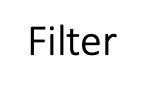
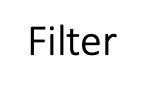
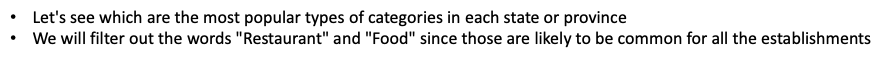
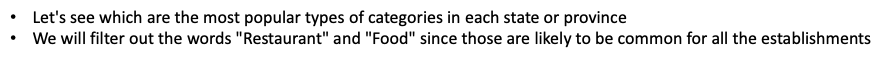
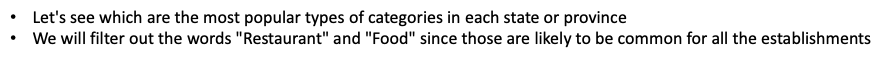
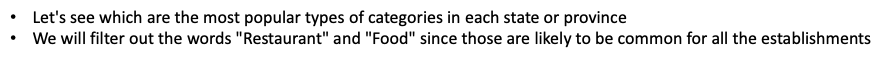

In [ ]:
# Clean, filter, and count restaurant categories
print(business_df %>%
  filter(str_detect(categories, "Restaurant")) %>%             # Keep only restaurant rows
  mutate(categories_new = strsplit(categories, ",")) %>%       # Split multiple categories
  unnest(categories_new) %>%                                   # Expand each category into its own row
  select(name, categories_new) %>%                             # Keep name and category columns
  mutate(categories_new = str_trim(str_squish(categories_new))) %>%  # Remove extra spaces
  filter(!categories_new %in% c("Restaurants", "Food")) %>%    # Exclude generic labels
  count(categories_new) %>%                                    # Count how often each category appears
  arrange(desc(n)))                                            # Sort by most frequent categories


# Data Analysis
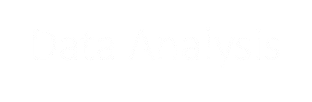
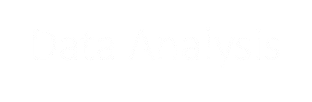
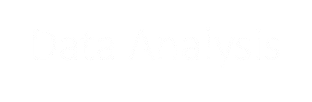
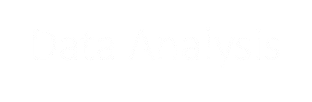

1. Show the number of Different categories besides Restaurants and Food, in each state/province?

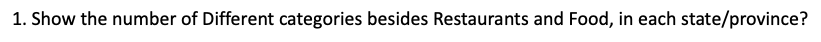
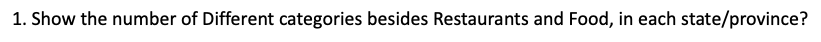
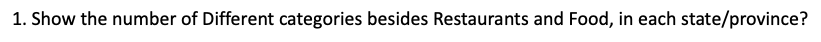
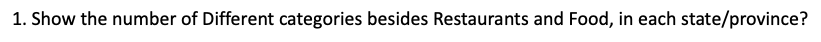

In [ ]:
# 1. Show the number of different categories besides Restaurants and Food, in each state/province

business_df %>%
  mutate(categories = strsplit(categories, ",")) %>%
  unnest(categories) %>%
  select(state, categories) %>%
  mutate(categories = str_trim(str_squish(categories))) %>%
  filter(!(categories %in% c("Restaurants", "Food"))) %>%  ## Filter out multiple categories
  group_by(state, categories) %>%
  count(categories) %>%
  arrange(state, desc(n))


2. How many establishments are there in each state that have the word “Restaurants” as one of their categories
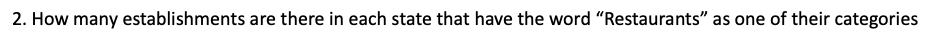
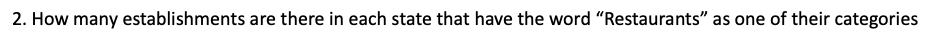
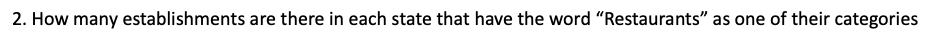
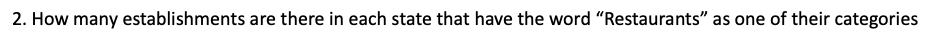

In [ ]:
business_df %>%
  mutate(categories = strsplit(categories, ",")) %>%
  unnest(categories) %>%
  select(state, categories) %>%
  mutate(categories = str_trim(str_squish(categories))) %>%
  filter(categories == "Restaurants") %>%  ## Filter out non-restaurants
  group_by(state, categories) %>%
  count(categories) %>%
  arrange(desc(n))


3. How many records are there for each state?


In [ ]:
business_df %>%
  select(state) %>%
  group_by(state) %>%
  count(state) %>%
  arrange(desc(n))


4. How many establishments are open

In [ ]:
business_df %>%
  select(is_open) %>%
  count(is_open) %>%
  arrange(desc(n))


5. How many establishments are open in each state. Sort ascending by state and whether or not they are open.


In [ ]:
business_df %>%
  select(state, is_open) %>%
  count(state, is_open) %>%
  arrange(state, desc(is_open))


6. Show the top 10 states in terms of median star review scores. 
Do not include the state XWY. Organize the star ratings in descending order.


In [ ]:
business_df %>%
  filter(state != "XWY") %>%
  type_convert(cols(stars = col_double())) %>%  ## Make sure that your star ratings are converted to a double
  select(state, stars) %>%
  group_by(state) %>%
  summarize(Stars = median(stars)) %>%
  arrange(desc(Stars)) %>%
  head(10)


7. Show the bottom 5 states in terms of median star review scores. 
Also show the total number of review scores that they have received

In [ ]:
business_df %>%
  filter(state != "XWY") %>%
  type_convert(cols(stars = col_double())) %>%
  select(state, review_count, stars) %>%
  group_by(state) %>%
  summarize(Median_Stars = median(stars),
            Number_of_Reviews = sum(review_count)) %>%
  arrange(Median_Stars) %>%
  head(5)


**Read the Yelp reviews JSON file**

In [ ]:
reviews_df <- jsonlite::stream_in(
  # Open the file from the Kaggle input folder
  file("/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json"),
 )

8. Show the establishment with the most 5 star reviews (top 5)


In [ ]:
# To answer this question we need to join the business and reviews tables, 
# then count the number of 5 star reviews for each business.

glimpse(business_df)
glimpse(reviews_df)

9. Join the tables by business_id

In [ ]:
business_reviews <- business_df %>%
  left_join(reviews_df, by = "business_id")


In [ ]:
# Look at the structure of the merged table.
# Note that the columns we need are business_id, name, stars.y
glimpse(business_reviews)


10. Show the establishments with the most number of 5-star reviews (top 5)


In [ ]:

business_reviews %>%
  filter(stars.y == 5) %>%                      # Keep only 5-star reviews
  group_by(business_id, name) %>%               # Group by business ID and name
  summarise(Five_Star_Reviews = n()) %>%        # Count number of 5-star reviews
  arrange(desc(Five_Star_Reviews)) %>%          # Sort from most to least
  head(5)                                       # Display top 5 establishments


11. Which 5 businesses appear the most times in the dataset

In [ ]:
# Order the businesses by how many times they appear

business_reviews %>%
  group_by(name) %>%          # Group data by business name
  summarise(Count = n()) %>%  # Count how many times each name appears
  arrange(desc(Count)) %>%    # Sort from highest to lowest count
  head(5)                     # Show the top 5 most frequent businesses


12. Show the number of Starbucks in each state


In [ ]:
business_reviews %>%
  filter(name == "Starbucks") %>%     # Keep only rows where the business name is "Starbucks"
  group_by(state) %>%                 # Group data by state
  summarise(Count = n()) %>%          # Count how many Starbucks locations per state
  arrange(desc(Count))                # Sort results from most to fewest


13. What percentage of Starbucks 'useful' scores are blank?

In [ ]:
business_reviews %>%
  filter(name == "Starbucks") %>%                  # Keep only Starbucks reviews
  group_by(useful) %>%                             # Group by the 'useful' score
  summarise(Count = n()) %>%                       # Count how many of each score
  arrange(desc(Count)) %>%                         # Sort from most to fewest
  mutate(Percentage = round(Count / sum(Count) * 100, 2)) %>%  # Calculate % of each group
  arrange(desc(useful))                            # Order by useful score


14. Show the proportion of visitors to Yelp's site who rated Starbucks funny reviews 6–11


In [ ]:
business_reviews %>%
  filter(name == "Starbucks") %>%                   # Keep only Starbucks reviews
  group_by(funny) %>%                               # Group by the 'funny' rating
  summarise(Count = n()) %>%                        # Count how many of each rating
  arrange(desc(Count)) %>%                          # Sort by most frequent ratings
  mutate(Percentage = round(Count / sum(Count) * 100, 2)) %>%  # Calculate % of each rating
  filter(funny > 5 & funny < 12) %>%                # Keep ratings between 6 and 11
  arrange(desc(funny))                              # Order by rating descending


15. Show the proportion of visitors to Yelp's site who rated the Starbucks 'cool' reviews below 5


In [ ]:

business_reviews %>%
  filter(name == "Starbucks") %>%                     # Keep only Starbucks reviews
  group_by(cool) %>%                                 # Group by the 'cool' rating
  summarise(Count = n()) %>%                         # Count how many reviews for each rating
  arrange(desc(Count)) %>%                           # Sort from most to fewest ratings
  mutate(Percentage = round(Count / sum(Count) * 100, 2)) %>%  # Calculate % for each rating
  filter(cool < 5) %>%                               # Keep ratings below 5
  summarise(Freq = sum(Percentage))                  # Sum percentages to get total share below 5


16. How many businesses have the same name in the dataset?


In [ ]:
# First, determine how many unique business IDs there are
unique_business_ids <- business_df %>%
  distinct(business_id) %>%
  count()

# Next, determine how many unique business names there are
unique_business_names <- business_df %>%
  distinct(name) %>%
  count()

# Find the difference between the unique business IDs and the unique business names
unique_business_ids - unique_business_names


# Test Analysis
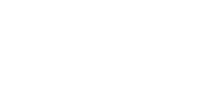
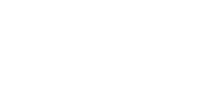
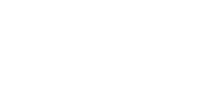
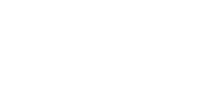

## Sentiment Analysis

Let’s try to gauge the sentiment in the reviews
We will attempt to 
1.  identify the most negative and positive 
2. assign sentiment scores to each review
3. chart the review scores

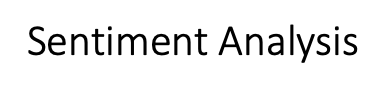
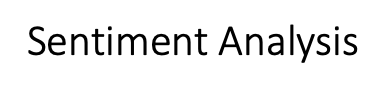
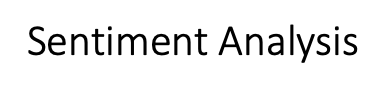
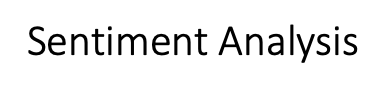
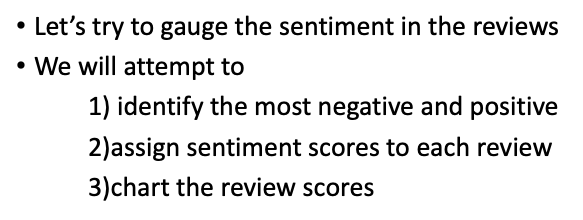
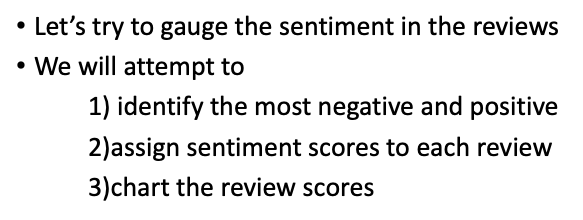
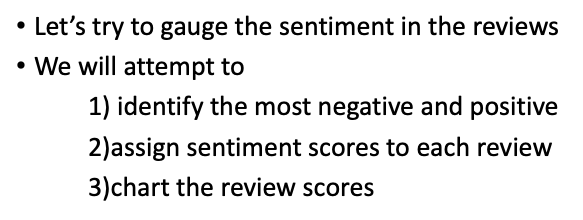
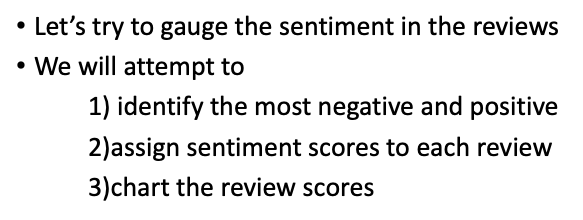

**Install tidytext if not already installed & Load AFINN sentiment lexicon**

In [ ]:

# This code ensures the tidytext package is available for text analysis and manually loads the AFINN sentiment lexicon from a CSV file to provide word sentiment scores for analysis.
install.packages("tidytext")
library(tidytext)

# Manually create the AFINN lexicon from a local CSV version
afinn <- read.csv("https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt",
                  sep = "\t", header = FALSE)
colnames(afinn) <- c("word", "value")

head(afinn)



**Let's only analyze Starbucks reviews**

In [ ]:

starbucks_reviews <- business_reviews %>%
  filter(name == "Starbucks")


**Calculate Sentiment Score**

A sentiment score is a numerical value that represents the emotional tone of a piece of text — showing whether it’s positive, negative, or neutral.

In [ ]:
# Calculate average sentiment score for each Starbucks review
customer_sentiment <- starbucks_reviews %>%
  unnest_tokens(word, text) %>%          # Split review text into individual words
  inner_join(afinn, by = "word") %>%     # Add sentiment scores from AFINN lexicon
  group_by(review_id) %>%                # Group words by each review
  summarize(sentiment = mean(value),     # Average sentiment score per review
            words = n()) %>%             # Count words in each review
  ungroup() %>%                          # Remove grouping
  filter(words >= 5)                     # Keep reviews with 5+ words

# View the resulting sentiment data
customer_sentiment





**Find the 10 most negative Starbucks reviews**

In [ ]:
customer_sentiment %>%
  arrange(sentiment) %>%                     # Sort reviews from most negative to most positive
  top_n(-10, sentiment) %>%                  # Select the 10 lowest sentiment scores (most negative)
  inner_join(starbucks_reviews, by = "review_id") %>%  # Add review details (address, city, date, text)
  select(address, city, date, sentiment, text)          # Keep only relevant columns for display



**Find the 10 most positive Starbucks reviews**

In [ ]:
customer_sentiment %>%
  arrange(desc(sentiment)) %>%                  # Sort reviews from most positive to most negative
  top_n(10, sentiment) %>%                      # Select the top 10 highest sentiment scores
  inner_join(starbucks_reviews, by = "review_id") %>%  # Add review details (address, city, date, text)
  select(address, city, date, sentiment, text)          # Keep only relevant columns for display



#  Create a Wordcloud

Here’s a simple 3-step outline of the process to create word clouds based on your code:

1️⃣ Prepare the text data: Extract the desired reviews (e.g., negative ones) and clean them using the tm package — removing numbers, punctuation, extra spaces, and stopwords.

2️⃣ Create a document-term matrix: Convert the cleaned text into a TermDocumentMatrix and compute word frequencies from it.

3️⃣ Generate the word cloud: Use the wordcloud() function with frequencies and visual options (e.g., colors, rotation, max words) to display the most frequent words visually.

In [ ]:
# Install Required Packages
install.packages("wordcloud")    # Installs the 'wordcloud' package for visualizing word frequencies
library(wordcloud)               # Loads the 'wordcloud' package

install.packages("RColorBrewer") # Installs 'RColorBrewer' for color palettes used in plots
library(RColorBrewer)            # Loads 'RColorBrewer' package

install.packages("tm")           # Installs the 'tm' package for text mining and cleaning
library(tm)                      # Loads the 'tm' package



**Prepare text data: Create a vector containing only the most negative Starbucks reviews**



In [ ]:
negative_text <- customer_sentiment %>%
  arrange(sentiment) %>%                        # Sort reviews from most negative to most positive
  top_n(-20, sentiment) %>%                     # Select the 20 most negative reviews
  inner_join(starbucks_reviews, by = "review_id") %>%  # Add the original review details
  select(text)                                  # Keep only the review text column

negative_text                                   # Display the negative review texts



**Prepare text data: Create a corpus that can be cleaned using the 'tm' package**

In [ ]:
negative_docs <- Corpus(VectorSource(negative_text))  # Convert the negative reviews into a text corpus



**Prepare text data: Clean Text**

In [ ]:
negative_docs <- negative_docs %>%
  tm_map(removeNumbers) %>%            # Remove all numbers
  tm_map(removePunctuation) %>%        # Remove punctuation marks
  tm_map(stripWhitespace)              # Remove extra spaces

negative_docs <- tm_map(negative_docs, content_transformer(tolower))           # Convert all text to lowercase
negative_docs <- tm_map(negative_docs, removeWords, stopwords("english"))      # Remove common English stopwords



**Create a document-term matrix: Create a term frequency table showing which words appear most often in your cleaned negative reviews.**

In [ ]:
# Create a document-term matrix
dtm <- TermDocumentMatrix(negative_docs)      # Create a matrix of terms (rows) and documents (columns)
matrix <- as.matrix(dtm)                      # Convert the document-term matrix into a standard R matrix
words <- sort(rowSums(matrix), decreasing = TRUE)  # Sum word frequencies and sort them from highest to lowest
words                                          # Display the sorted word frequencies


**Convert the document-term-matrix to a data frame**


In [ ]:
df <- data.frame(word = names(words), freq = words)
df


**Convert the document-term-matrix to a data frame**


In [ ]:
df <- data.frame(word = names(words), freq = words)
df


**Create a wordcloud**

In [ ]:
# Create a word cloud visualization
wordcloud(
  words = df$word,                # Words to display
  freq = df$freq,                 # Corresponding word frequencies
  min.freq = 5,                   # Only include words appearing at least 5 times
  max.words = 200,                # Limit the total number of words shown
  random.order = FALSE,           # Arrange words by frequency (not randomly)
  rot.per = 0.35,                 # Percentage of words rotated vertically
  colors = brewer.pal(8, "Dark2") # Use a color palette from RColorBrewer
)
